# PolyA tail lengths

Code to generate polyA tail length plots:

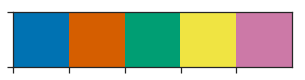

In [1]:
import sys
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.5, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [4]:
datasets = [
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/polya_tails/201901_col0_2916_polya_lengths.tsv.gz',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/polya_tails/201901_col0_2917_polya_lengths.tsv.gz',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/polya_tails/201901_col0_2918_polya_lengths.tsv.gz',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/polya_tails/201901_col0_2919_polya_lengths.tsv.gz',
]


In [6]:
polya_lengths = {}

for fn in datasets:
    sample = os.path.split(fn)[1].split('_polya_')[0]
    p = pd.read_table(
        fn, sep='\t',
        usecols=['readname', 'contig', 'position', 'polya_length', 'qc_tag'],
        na_values=['-1'],
        dtype={'readname': str, 'contig': str, 'position': int, 'polya_length': float, 'qc_tag': 'category'},
        index_col='readname'
    )
    polya_lengths[sample] = p
polya_lengths = pd.concat(polya_lengths, axis=0)
polya_lengths.head()

contig  position  \
                 readname                                                
201901_col0_2916 838eac53-279a-4687-b4f8-e60824bb349f      1     30710   
                 b15e3bf9-4848-4977-9372-c4fdb848b3ec      1     30255   
                 84ba92fc-e607-46f3-a020-10114a13273b      1      6874   
                 e80d07de-8ac4-4793-b0e4-5ffb4f3071f2      1      6758   
                 0aea8df7-e207-44f8-bcc9-45ca998a8273      1      6877   

                                                       polya_length  \
                 readname                                             
201901_col0_2916 838eac53-279a-4687-b4f8-e60824bb349f           NaN   
                 b15e3bf9-4848-4977-9372-c4fdb848b3ec        198.31   
                 84ba92fc-e607-46f3-a020-10114a13273b        148.81   
                 e80d07de-8ac4-4793-b0e4-5ffb4f3071f2        162.24   
                 0aea8df7-e207-44f8-bcc9-45ca998a8273         93.84   

                                                                 qc_tag  
                 readname                                                
201901_col0_2916 838eac53-279a-4687-b4f8-e60824bb349f  READ_FAILED_LOAD  
                 b15e3bf9-4848-4977-9372-c4fdb848b3ec           ADAPTER  
                 84ba92fc-e607-46f3-a020-10114a13273b              PASS  
                 e80d07de-8ac4-4793-b0e4-5ffb4f3071f2           ADAPTER  
                 0aea8df7-e207-44f8-bcc9-45ca998a8273              PASS

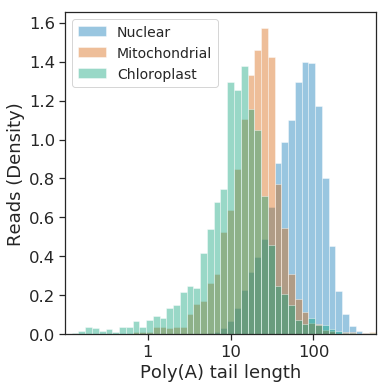

In [7]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
mt = polya_lengths[polya_lengths.contig == 'Mt']
pt = polya_lengths[polya_lengths.contig == 'Pt']
nc = polya_lengths[~polya_lengths.contig.isin(['Mt', 'Pt'])]
sns.distplot(np.log10(nc.dropna().polya_length + 0.01),
             hist=True, kde=False,
             bins=np.linspace(-1, 3, 50),
             hist_kws={'density': True},
             label='Nuclear')
sns.distplot(np.log10(mt.dropna().polya_length + 0.01),
             hist=True, kde=False,
             bins=np.linspace(-1, 3, 50),
             hist_kws={'density': True},
             label='Mitochondrial')
sns.distplot(np.log10(pt.dropna().polya_length + 0.01),
             hist=True, kde=False,
             bins=np.linspace(-1, 3, 50),
             hist_kws={'density': True},
             label='Chloroplast')
ax.set_xlabel('Poly(A) tail length')
ax.set_ylabel('Reads (Density)')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_xlim(-1, 2.75)
ax.legend(fontsize=14)
plt.tight_layout()
plt.savefig('polya_tail_length_dist.svg', transparent=True)
plt.show()

In [8]:
nc.polya_length.mean()

76.47336513309031

In [9]:
nc.polya_length.describe(percentiles=(.975, 0.025))['2.5%'], nc.polya_length.describe(percentiles=(.975, 0.025))['97.5%']

(13.41, 196.84049999999814)

In [11]:
vir1_pa_dists = pd.read_csv(
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/notebooks/data/vir1_vs_col0_polya.tsv',
    sep='\t',
    names=['chrom', 'start', 'end', 'gene_id',
           'score', 'strand', 'nreads_col0', 'nreads_vir1',
           'median_col0', 'ci_lower_col0', 'ci_upper_col0',
           'median_vir1', 'ci_lower_vir1', 'ci_upper_vir1',
           'ks', 'ks_p_val', 'ks_fdr',
           'mwu', 'mwu_p_val', 'mwu_fdr']
)

vir1_pa_dists['cpm_col0'] = vir1_pa_dists['nreads_col0'] / vir1_pa_dists['nreads_col0'].sum(0) * 1_000_000
vir1_pa_dists['cpm_vir1'] = vir1_pa_dists['nreads_vir1'] / vir1_pa_dists['nreads_vir1'].sum(0) * 1_000_000
vir1_pa_dists['med_change'] = vir1_pa_dists['median_vir1'] - vir1_pa_dists['median_col0']
vir1_pa_dists.head()

,chrom,start,end,gene_id,score,strand,nreads_col0,nreads_vir1,median_col0,ci_lower_col0,...,ci_upper_vir1,ks,ks_p_val,ks_fdr,mwu,mwu_p_val,mwu_fdr,cpm_col0,cpm_vir1,med_change
0,1,31169,33171,AT1G01050,0.238514,-,45,47,68.169998,15.035000,...,241.488496,0.157920,0.577412,0.961353,898.5,0.107856,0.389911,96.062300,62.509892,14.120003
1,1,33364,37871,AT1G01060,0.128895,-,12,32,68.945000,25.178000,...,186.448251,0.218750,0.743199,0.996127,182.0,0.401156,0.490438,25.616613,42.559926,12.420002
2,1,44969,47059,AT1G01080,0.021193,-,24,61,103.040001,17.694249,...,205.600006,0.120219,0.952374,1.000000,685.0,0.324926,0.476891,51.233226,81.129860,-2.629997
3,1,47233,49304,AT1G01090,0.156813,-,72,78,83.704998,34.993001,...,151.514257,0.113248,0.696927,0.994525,2721.0,0.372443,0.486337,153.699679,103.739821,2.430004
4,1,49908,51210,AT1G01100,1.955502,-,415,357,58.169998,14.009000,...,145.250006,0.115285,0.011079,0.308539,64624.0,0.001107,0.073091,885.907874,474.809179,-10.369999


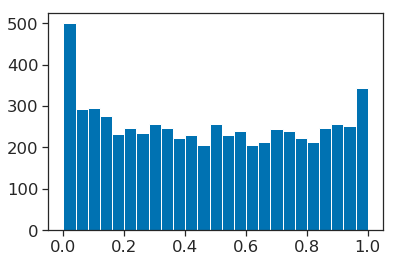

In [12]:
plt.hist(vir1_pa_dists.ks_p_val, bins=25)
plt.show()

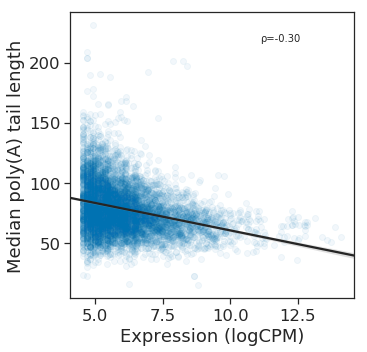

In [14]:
fig, ax = plt.subplots(figsize=(5.2, 5))
plt.tight_layout()
nuclear_only = vir1_pa_dists[vir1_pa_dists.chrom.isin(list('12345'))]

sns.regplot(
    x=np.log2(nuclear_only.cpm_col0),
    y=nuclear_only.median_col0,
    scatter_kws={'alpha': 0.05, 'rasterized': True},
    line_kws={'color': '#252525'},
    lowess=False, ax=ax
)

ax.set_xlabel('Expression (logCPM)')
ax.set_ylabel('Median poly(A) tail length')

rho, p = stats.spearmanr(nuclear_only.cpm_col0, nuclear_only.median_col0)

ax.annotate(xy=(0.67, 0.9), s=f'ρ={rho:.2f}', xycoords='axes fraction')

plt.tight_layout()
plt.savefig('polya_length_vs_expression.svg')
plt.show()

In [15]:
boot_res = []

s = nuclear_only.loc[:, ['cpm_col0', 'median_col0']]
n = len(s)

for _ in range(10_000):
    samp = s.sample(n=n, replace=True)
    boot_res.append(stats.spearmanr(samp['cpm_col0'], samp['median_col0'])[0])

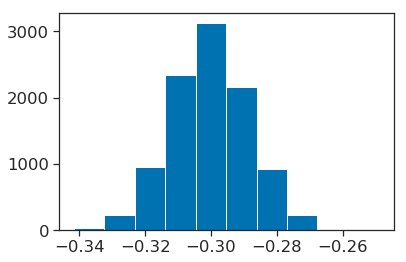

In [16]:
plt.hist(boot_res)
plt.show()

In [17]:
np.percentile(boot_res, (2.5, 97.5))

array([-0.32340467, -0.27711211])

In [18]:
from chimerID.io import parse_gtf_flat_exon_invs, parse_pysam_aln
from chimerID.intervals import intersect_spliced_invs


def get_polya_dist(chrom, start, end, strand, bam, gene_invs=None,
                   overlap_thresh=200, gene_frac_thresh=0.2,
                   read_frac_thresh=0.25):
    if gene_invs is None:
        gene_invs = [[start, end]]
    gene_ln = sum([e - s for s, e in gene_invs])
    polya_lengths = []
    for aln in bam.fetch(chrom, start, end):
        *_, read_id, read_strand, read_invs, _, _  = parse_pysam_aln(aln)
        if strand != read_strand:
            continue
        read_ln = sum([e - s for s, e in read_invs])
        abs_overlap = intersect_spliced_invs(gene_invs, read_invs)
        read_frac = abs_overlap / read_ln
        gene_frac = abs_overlap / gene_ln
        if abs_overlap >= overlap_thresh and \
               read_frac >= read_frac_thresh and \
               gene_frac >= gene_frac_thresh:
            pa = aln.get_tag('pA')
            polya_lengths.append(pa)
    return np.array(polya_lengths)


def plot_overlayed_dists(*args, query, bins, clip, colors, title, log=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    for i, group in enumerate(args):
        group_p_a = []
        for bam_fn in group:
            with pysam.AlignmentFile(bam_fn) as bam:
                p_a = get_polya_dist(*query, bam)
            group_p_a.append(p_a)
        group_p_a = np.concatenate(group_p_a)
        if log:
            group_p_a = np.log10(group_p_a)
        sns.distplot(group_p_a, bins=bins, kde_kws=dict(clip=clip), hist_kws=dict(alpha=0.2), color=colors[i], ax=ax)
    ax.set_xlabel('polyA length')
    ax.set_title(title)
    return ax

In [27]:
col0_datasets = [
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/201901_col0_2916.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/201901_col0_2917.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/201901_col0_2918.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/201901_col0_2919.with_pA_tag.bam'
]

VIRc_datasets = [
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180907_1420_20180907_VIRGFP_2929_mRNA/aligned_data/201902_VIRcompl_2929.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180301_1825_20180301_FAH54216_VIRcomp_2928_DRS/aligned_data/20190317_VIRc_2928.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180925_1320_20180925_VIRcompl_2931_mRNA/aligned_data/201812_VIRcompl_2931.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20181019_1436_20181019_VIRcomp_mRNA_2930_Anya/aligned_data/201812_VIRcomp_2930.with_pA_tag.bam'
]

vir1_datasets = [
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180912_1424_20180912_vir1_2923_mRNA/aligned_data/201902_vir1_2923.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180928_1515_vir-1_20180929_2924_mRNA/aligned_data/201902_vir1_2924.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20181003_1345_20181003_mRNA_vir_2925/aligned_data/201902_vir1_2925.with_pA_tag.bam',
    '/cluster/ggs_lab/mtparker/nanopolish_polya_pipeline/20180227_1832_20180227_FAH59351_vir1_2922_DRS/aligned_data/20190317_vir1_2922.with_pA_tag.bam'
]


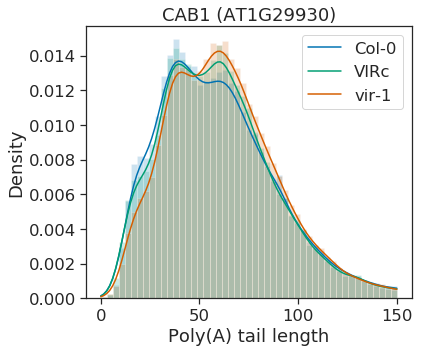

In [28]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_overlayed_dists(
    col0_datasets,
    VIRc_datasets,
    vir1_datasets,
    query=('1', 10477885, 10479114, '+'),
    log=False,
    bins=np.linspace(0, 150, 50),
    clip=(0, 150),
    colors=[pal[0], pal[2], pal[1]],
    title='CAB1 (AT1G29930)',
    ax=ax
)
ax.plot([], [], color=pal[0], label='Col-0')
ax.plot([], [], color=pal[2], label='VIRc')
ax.plot([], [], color=pal[1], label='vir-1')
ax.legend()
ax.set_xlabel('Poly(A) tail length')
ax.set_ylabel('Density')
plt.tight_layout()
plt.savefig('cab1_polya_tail_length_distribution.svg')
plt.show()